In [59]:
import requests
from bs4 import BeautifulSoup
import os
import pandas as pd
from tqdm.notebook import tqdm
import re
import datetime
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.linear_model import LinearRegression

In [25]:
OUTPUT_PATH = "./excels/"
CLASSMENT_URL = "https://www.vendeeglobe.org/fr/classement"
BASE_URL = "https://www.vendeeglobe.org/download-race-data/vendeeglobe_"
OUT = "./excel_post/"

# 1 - Importation des données
Récupération des fichiers Excels

In [2]:
# Télécharge la liste des liens vers les excels
def get_classment_links():
    return_list = []
    r = requests.get(CLASSMENT_URL)
    soup = BeautifulSoup(r.text)
    options = soup.select_one(".onsubmit-rank").select("option")
    for opt in options:
        val = opt.attrs["value"]
        if val != "":
            return_list.append(val)
    return return_list

In [3]:
def download_file(link):
    r = requests.get(BASE_URL + link + ".xlsx", allow_redirects=True)
    open(OUTPUT_PATH + link + ".xlsx", 'wb').write(r.content)

In [8]:
links = get_classment_links()

for i in tqdm(range(len(links))):
    download_file(links[i])

  0%|          | 0/706 [00:00<?, ?it/s]

Transformation des excels avec XL_Wings

In [5]:
import xlwings as xw

files = os.listdir(OUTPUT_PATH)

for i in tqdm(range(len(files))):
    file = files[i]
    excel_app = xw.App(visible=False)
    excel_book = excel_app.books.open(OUTPUT_PATH + file)
    excel_book.save(OUT + file)
    excel_book.close()
    excel_app.quit()

NameError: name 'OUTPUT_PATH' is not defined

# Creation d'un Dataframe

In [41]:
def extract_num(val):
    matchs = re.findall("[0-9.]+", val)
    if len(matchs) == 0:
        return 0.0
    return float(matchs[0])

def parse_date(datestr, hour):
    return datetime.datetime(int(datestr[0:4]), int(datestr[4:6]), int(datestr[6:]), hour=int(hour[0:2]))

def handdle_gps(val):
    ret_val = 0

    if "°" in val:
        ret_val += int(val.split("°")[0])
        val = val.split("°")[1]

    matchs =  re.findall("[0-9]+", val)
    ret_val += float(matchs[0]) / 60
    ret_val += float(matchs[1]) / 3600
    
    if "S" in val or "W" in val:
        return -ret_val

    return ret_val

In [43]:
def load_excel(main_df, path, date):
    df = pd.read_excel(path, skiprows=3)
    for i in range(1, len(df)):
        try:
            main_df = main_df.append({
                "record_date": date, "Numéro voile": df["Nat. / Voile\nNat. / Sail"][i].split("\n")[1],
                "Cap": extract_num(df["Depuis le dernier classement\nSince the the last report"][i]),
                "DTF": extract_num(df["DTF"][i]),
                "Vitesse": extract_num(df["Unnamed: 13"][i]),
                "Latitude": handdle_gps(df["Unnamed: 5"][i]),
                "Longitude": handdle_gps(df["Unnamed: 6"][i]),
                "Classement": int(df["Rang\nRank"][i]),
                "Skipper": df["Skipper / Bateau\nSkipper / crew"][i].split("\n")[0]
            }, ignore_index=True)
        except:
            pass
    return main_df


main_df = pd.DataFrame({
    "record_date": pd.Series(dtype='str'), "Numéro voile": pd.Series(dtype='str'),
    "Skipper": pd.Series(dtype='str'), "Cap": pd.Series(dtype='float'),
    "Vitesse": pd.Series(dtype='float'), "DTF": pd.Series(dtype='float'),
    "Classement": pd.Series(dtype='int'),
    "Latitude": pd.Series(dtype='str'), "Longitude": pd.Series(dtype='str')
})

files = os.listdir(OUT)

# my_date = parse_date(files[10].split("_")[0], files[10].split("_")[1])
# main_df = load_excel(main_df, OUT + files[10], my_date)

for i in tqdm(range(len(files))):
    my_date = parse_date(files[i].split("_")[0], files[i].split("_")[1])
    main_df = load_excel(main_df, OUT + files[i], my_date)

print(main_df.head)

  0%|          | 0/703 [00:00<?, ?it/s]

<bound method NDFrame.head of               record_date Numéro voile         Skipper    Cap  Vitesse  \
0     2020-11-08 14:00:00       FRA 18    Louis Burton  357.0      0.0   
1     2020-11-08 14:00:00       MON 10  Boris Herrmann  357.0      0.0   
2     2020-11-08 14:00:00        FRA 8   Jérémie Beyou  357.0      0.0   
3     2020-11-08 14:00:00       FRA 59   Thomas Ruyant  357.0      0.0   
4     2020-11-08 14:00:00       FRA 53    Maxime Sorel  357.0      0.0   
...                   ...          ...             ...    ...      ...   
13698 2021-01-27 14:00:00       FRA 71   Manuel Cousin  355.0     13.0   
13699 2021-01-27 14:00:00       FRA 50  Miranda Merron  349.0     10.8   
13700 2021-01-27 14:00:00       FRA 83  Clément Giraud    1.0      9.8   
13701 2021-01-27 14:00:00       FRA 72  Alexia Barrier   23.0      9.0   
13702 2021-01-27 14:00:00      FIN 222     Ari Huusela   38.0     10.7   

           DTF  Classement   Latitude  Longitude  
0      24293.9           1  46

In [174]:
r = requests.get("https://www.vendeeglobe.org/fr/glossaire")
soup = BeautifulSoup(r.text)

ships_detail = pd.DataFrame({
    "Numéro voile": pd.Series(dtype='str'),
    "Anciens noms du bateau": pd.Series(dtype='str'),
    "Architecte": pd.Series(dtype='str'),
    "Chantier": pd.Series(dtype='str'),
    "Date de lancement": pd.Series(dtype='str'),
    "Longueur": pd.Series(dtype='float'),
    "Largeur": pd.Series(dtype='float'),
    "Tirant d'eau": pd.Series(dtype='float'),
    "Poids": pd.Series(dtype='float'),
    "Hauteur mât": pd.Series(dtype='float'),
    "Surface de voiles au près": pd.Series(dtype='float'),
    "Surface de voiles au portant": pd.Series(dtype='float'),
    "Dérive": pd.Series(dtype='int'),
    "Foil": pd.Series(dtype='int')
})

ships = soup.select(".boats-list__popup-infos")
for ship in ships:
    items = ship.select("li")
    value_map = {}
    for itm in items:
        if "Numéro de voile" in itm.text:
            value_map["Numéro voile"] = itm.text.split("Numéro de voile :")[1]

        elif "Anciens noms du bateau" in itm.text:
            value_map["Anciens noms du bateau"] = itm.text.split("Anciens noms du bateau :")[1]

        elif "Architecte" in itm.text:
            value_map["Architecte"] = itm.text.split("Architecte :")[1]

        elif "Longueur" in itm.text:
            value_map["Longueur"] = extract_num(itm.text.split("Longueur :")[1])
        
        elif "Largeur" in itm.text:
            value_map["Largeur"] = extract_num(itm.text.split("Largeur :")[1])

        elif "Hauteur mât" in itm.text:
            value_map["Hauteur mât"] = extract_num(itm.text.split("Hauteur mât :")[1])

        elif "Surface de voiles au près" in itm.text:
            value_map["Surface de voiles au près"] = extract_num(itm.text.split("Surface de voiles au près :")[1])

        elif "Surface de voiles au portant" in itm.text:
            value_map["Surface de voiles au portant"] = extract_num(itm.text.split("Surface de voiles au portant :")[1])

        elif "Tirant d'eau" in itm.text:
            value_map["Tirant d'eau"] = extract_num(itm.text.split("Tirant d'eau :")[1])

        elif "Chantier" in itm.text:
            value_map["Chantier"] = itm.text.split("Chantier :")[1]

        elif "Date de lancement" in itm.text:
            matches = re.findall("20[0-9]{2}", itm.text)
            if len(matches) != 0:
                value_map["Date de lancement"] = int(matches[0])

        elif "dérives" in itm.text:

            if "foils" in itm.text:
                value_map["Foil"] = 1
                value_map["Dérive"] = 0
            else:
                value_map["Dérive"] = extract_num(itm.text.split("Nombre de dérives :")[1])
                value_map["Foil"] = 0

        elif "Déplacement (poids)" in itm.text:
            try:
                value_map["Poids"] = extract_num(itm.text.split("Déplacement (poids) :")[1])
            except:
                pass
    
    if "Numéro voile" in value_map:
        if "Date de lancement" not in value_map:
            # remplace par la moyenne
            value_map["Date de lancement"] = 2011
        ships_detail = ships_detail.append(value_map, ignore_index=True)

ships_detail

,Numéro voile,Anciens noms du bateau,Architecte,Chantier,Date de lancement,Longueur,Largeur,Tirant d'eau,Poids,Hauteur mât,Surface de voiles au près,Surface de voiles au portant,Dérive,Foil
0,FRA 56,"No Way Back, Vento di Sardegna",VPLP/Verdier,Persico Marine,2015,18.0,5.0,4.0,7.0,29.0,320.0,570.0,0.0,1
1,FRA 49,"Gitana Eighty, Synerciel, Newrest-Matmut",Bruce Farr Design,Southern Ocean Marine (Nouvelle Zélande),2007,18.0,5.0,4.0,9.0,28.0,280.0,560.0,2.0,0
2,FRA72,"Famille Mary-Etamine du Lys, Initiatives Coeu...",Marc Lombard,MAG France,2011,18.0,5.0,4.0,9.0,29.0,260.0,580.0,2.0,0
3,17,Safran 2 - Des Voiles et Vous,Verdier - VPLP,CDK Technologies,2015,18.0,5.0,4.0,8.0,29.0,310.0,550.0,0.0,1
4,08,NaN,VPLP,CDK Technologies,2018,18.0,5.0,4.0,8.0,29.0,320.0,600.0,0.0,1
5,FRA 14,"Ecover3, Président, Gamesa, Kilcullen Voyager...",Owen Clarke Design LLP - Clay Oliver,Hakes Marine - Mer Agitée,2007,18.0,5.0,4.0,7.0,29.0,300.0,610.0,0.0,1
6,18,Banque Populaire VIII,Verdier - VPLP,CDK Technologies,2015,18.0,5.0,4.0,7.0,28.0,300.0,600.0,0.0,1
7,ESP 33,Kingfisher - Educacion sin Fronteras - Forum ...,Owen Clarke Design,Martens Yachts,2000,18.0,5.0,4.0,8.0,26.0,240.0,470.0,2.0,0
8,FRA 71,"Paprec-Virbac2, Estrella Damm, We are Water, ...",Bruce Farr Yacht Design,Southern Ocean Marine (Nouvelle-Zélande),2007,18.0,5.0,4.0,9.0,28.0,270.0,560.0,2.0,0
9,FRA30,Macif - SMA,Verdier - VPLP,CDK - Mer Agitée,2011,18.0,5.0,4.0,7.0,29.0,340.0,570.0,2.0,0


Gestion des numéros de voile

In [156]:
voiles_nb = main_df["Numéro voile"].unique()
values = {}
for val in voiles_nb:
    values[int(extract_num(val))] = val

for i in range(len(ships_detail)):
    id = int(extract_num(ships_detail["Numéro voile"][i]))
    if id in values:
        ships_detail["Numéro voile"][i] = values[id]

merged = main_df.merge(ships_detail, on="Numéro voile")

C:\Users\charl\AppData\Local\Temp\ipykernel_25380\248952202.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ships_detail["Numéro voile"][i] = values[id]


# Interpretation

## Visualisation de la distance restante à parcourir en fonction du temps par skipper.

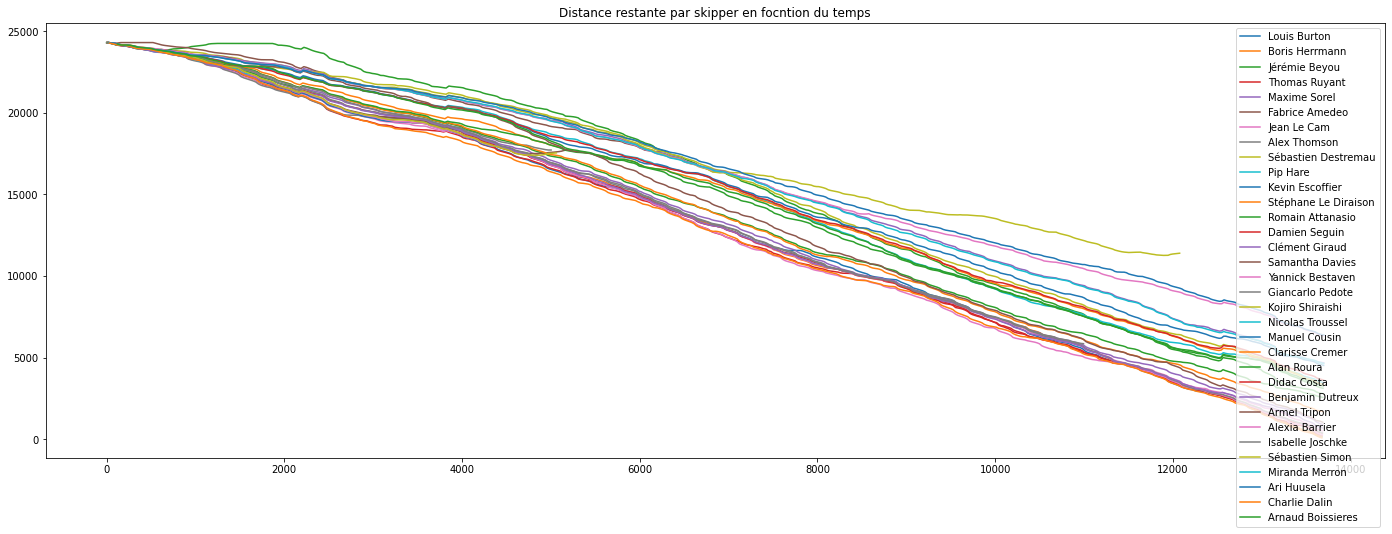

In [9]:
skippers = main_df["Skipper"].unique()

plt.figure(figsize=(24, 8))

for skipper in skippers:
    df = main_df[main_df["Skipper"] == skipper]
    plt.plot(df["DTF"], label=skipper)

plt.title("Distance restante par skipper en fonction du temps")
plt.legend()

## Affichage du trajet exact d'un skipper

<AxesSubplot:xlabel='Longitude', ylabel='Latitude'>

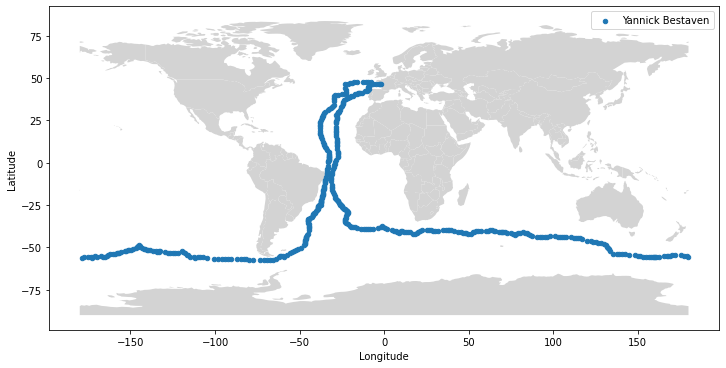

In [52]:
import geopandas as gpd

countries = gpd.read_file(
               gpd.datasets.get_path("naturalearth_lowres"))

fig, ax = plt.subplots(figsize=(12,8))

countries.plot(color="lightgrey", ax=ax)

skippers = main_df["Skipper"].unique()
    
skipper = "Yannick Bestaven"
main_df[main_df["Skipper"] == skipper].plot(x="Longitude", y="Latitude", kind="scatter", ax=ax, label=skipper)


## Analyse de l'évolution du classement

On va dans un premier temps chercher à afficher les évolution du classsement en fonction du temps. On consate sur le graphique ci-dessous que peus de choses sont en réalités jouées en un instant Tj, et que e classment ne cesse d'évoluer. On remarque une concentration particulièrement élevée des changements de positon au début de la course. On peut ainsi immaginer que le classmeent sur les premiers miles n'importe que peu.

[]

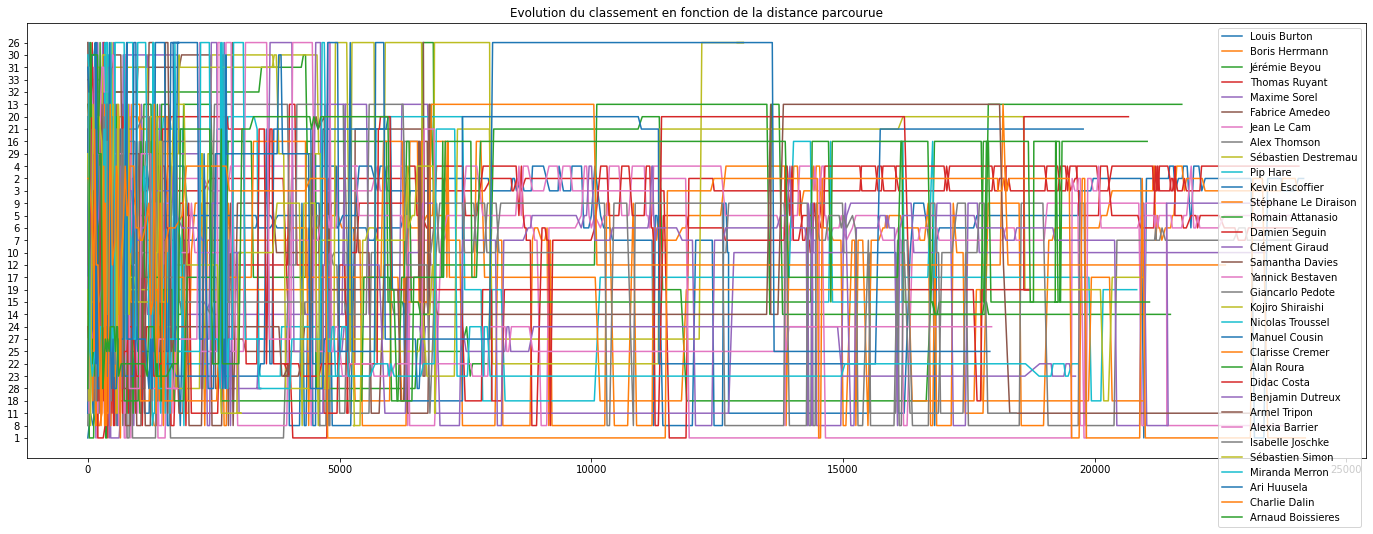

In [20]:
skippers = main_df["Skipper"].unique()

plt.figure(figsize=(24, 8))

for skipper in skippers:
    df = main_df[main_df["Skipper"] == skipper]
    plt.plot(np.max(df["DTF"]) - df["DTF"], df["Classement"], label=skipper)

plt.title("Evolution du classement en fonction de la distance parcourue")
plt.legend()
plt.plot()

Nous allons maintenant vérifier que l'importance du classement initial sur le classment final est quasiment nulle.

Coefficients du modèle de regression: [0.30272094]
Facteur de qualité 0.155398515609232


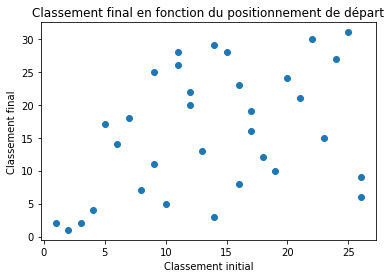

In [68]:
skippers = main_df["Skipper"].unique()

final = []
start = []

for skipper in skippers:
    df = main_df[main_df["Skipper"] == skipper]
    df = df.dropna()
    final.append(df["Classement"][np.max(df.index)])
    start.append(df["Classement"][np.min(df.index)])

plt.scatter(final, start)
plt.title("Classement final en fonction du positionnement de départ")
plt.ylabel("Classement final")
plt.xlabel("Classement initial")


model = LinearRegression().fit(np.array(start).reshape(-1,1), final)
print("Coefficients du modèle de regression:", model.coef_)
print("Facteur de qualité", model.score(np.array(start).reshape(-1,1), final))

La regression à montrée qu'il existe un lien entre le classment initial et le classement final d'un bateau. Cepededant, le facteur de qualité "R2" de cette regression est assez faible, nous montrant que la relation reste peu fiable.
Nous allons maintenant essayer de trouver des variables plus intéressantes pour tenter de prédire un classment avant l'issue de la course.
On commence par s'interesser au positionnement moyen au cours de la course :

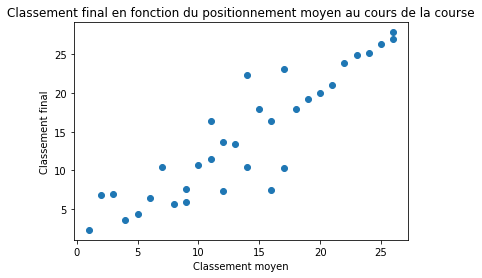

Coefficients du modèle de regression: [0.82450822]
Facteur de qualité 0.8097957545713117


In [64]:
skippers = main_df["Skipper"].unique()

final = []
mean = []

for skipper in skippers:
    df = main_df[main_df["Skipper"] == skipper]
    df = df.dropna()
    final.append(df["Classement"][np.max(df.index)])
    mean.append(np.mean(df["Classement"]))

plt.scatter(final, mean)
plt.title("Classement final en fonction du positionnement moyen au cours de la course")
plt.ylabel("Classement final")
plt.xlabel("Classement moyen")
plt.show()

model = LinearRegression().fit(np.array(mean).reshape(-1,1), final)
print("Coefficients du modèle de regression:", model.coef_)
print("Facteur de qualité", model.score(np.array(mean).reshape(-1,1), final))

On obtient ici un facteur de qualité beaucoup plus intéressant, nous informant que le positionnement moyen est une bonne information pour extrapoler le classement final.
Nous allons maintenant voir comment évoluent les différences entre le classement final et le classement instantané. On va ainsi calculer pour chaque instant la somme des différences entre le classement actuel et le classement final.

Text(0, 0.5, 'Différence absolue moyenne de classement')

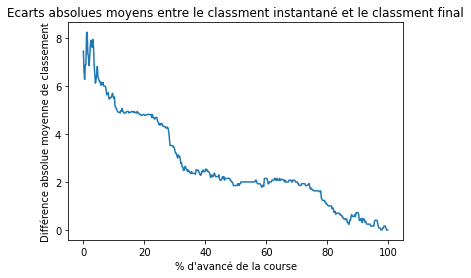

In [86]:
series = []
final_classement = []

for skipper in skippers:
    df = main_df[main_df["Skipper"] == skipper]
    df = df.reset_index()
    series.append(df)
    final_classement.append(df["Classement"][np.max(df.index)])

variance = []
for i in range(len(series[0])):
    changes = 0
    count  = 0
    for e in range(len(series)):
        if i < len(series[e]) and not math.isnan(series[e]["Classement"][i]):
            changes += abs(series[e]["Classement"][i] - final_classement[e])
            count += 1
    variance.append(changes / count)

plt.plot(np.array(range(0, len(variance))) / len(variance)*100, variance)
plt.title("Ecarts absolues moyens entre le classment instantané et le classment final")
plt.xlabel("% d'avancé de la course")
plt.ylabel("Différence absolue moyenne de classement")

On constate sur le graphique que plus la course avance plus l'écart entre le classement et le classement final se resserre.

### Analyse des corrélations entre spécifications du bateau et classement & vitesse

On va dans un premier temps regarder comment évoluent les vitesses des bateaux au cours de la course.

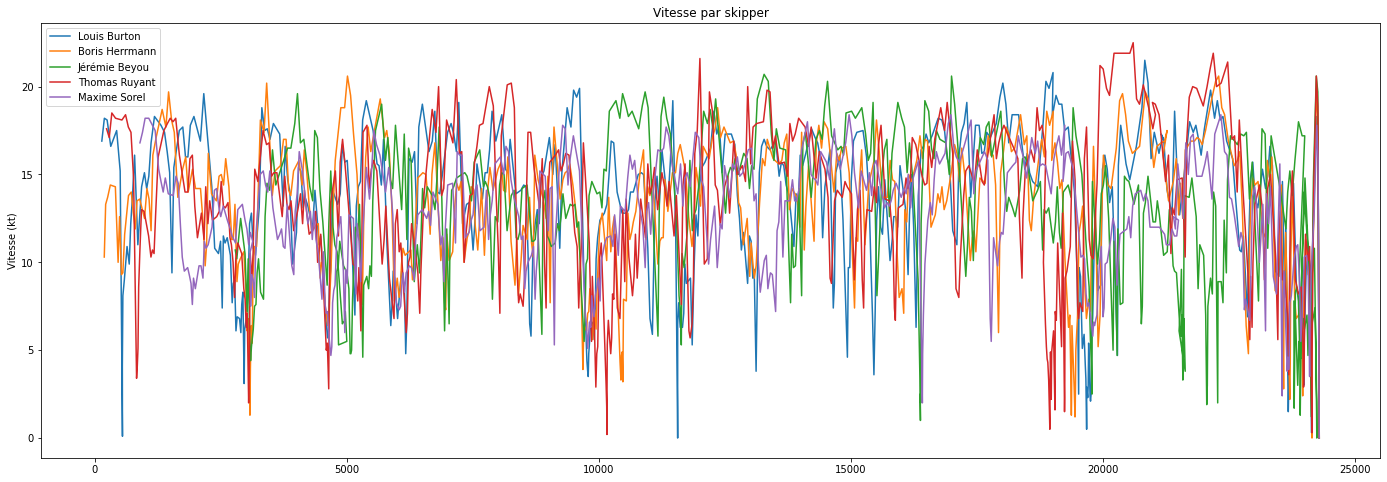

In [89]:
skippers = main_df["Skipper"].unique()

plt.figure(figsize=(24, 8))

for skipper in skippers[0:5]:
    df = main_df[main_df["Skipper"] == skipper]
    plt.plot(df["DTF"], df["Vitesse"], label=skipper)

plt.title("Vitesse par skipper")
plt.ylabel("Vitesse (kt)")
plt.legend()

On constate que la vitesse d'un bateau fluctue beaucoup au cours de la course, avec de nombreux arrêts pour tous les bateaux. Ainsi, pour analyser les performances des bateaux, il va falloir créer plusieurs variables dérivées des vitesses instantanées. On s'intéressera  donc :
- à la vitesse maximale enregistrée
- aux quantiles
- à la vitesse moyenne

In [158]:
speed_data = pd.DataFrame()


for skipper in skippers:
    df = main_df[main_df["Skipper"] == skipper]
    df = df.dropna()
    data = df["Vitesse"]
    speed_data = speed_data.append({
        "Numéro voile": df["Numéro voile"][df.index[0]],
        "skipper": df["Skipper"][df.index[0]],
        "max_speed": np.max(data),
        "avg_speed": np.mean(data),
        "median": np.quantile(data, 0.5),
        "top_75": np.quantile(data, 0.75),
        "top_25": np.quantile(data, 0.25),
        "var": np.std(data),
        "classement": df["Classement"][np.max(df.index)]
    }, ignore_index=True)


speed_data = speed_data.merge(ships_detail, on="Numéro voile")
speed_data

,Numéro voile,skipper,max_speed,avg_speed,median,top_75,top_25,var,classement,Anciens noms du bateau,...,Date de lancement,Longueur,Largeur,Tirant d'eau,Poids,Hauteur mât,Surface de voiles au près,Surface de voiles au portant,Dérive,Foil
0,FRA 18,Louis Burton,21.5,12.835062,13.95,16.600,9.700,4.695380,2.0,Banque Populaire VIII,...,2015,18.0,5.0,4.0,7.0,28.0,300.0,600.0,0.0,1
1,FRA 8,Jérémie Beyou,20.7,11.793361,12.65,15.375,8.500,4.965315,14.0,NaN,...,2018,18.0,5.0,4.0,8.0,29.0,320.0,600.0,0.0,1
2,FRA 53,Maxime Sorel,18.4,12.300207,12.65,15.000,10.000,3.352651,10.0,"Le Souffle du Nord, Groupe Bel",...,2007,18.0,5.0,4.0,7.0,29.0,365.0,700.0,2.0,0
3,FRA 56,Fabrice Amedeo,16.4,8.776000,9.30,12.725,5.600,4.551914,26.0,"No Way Back, Vento di Sardegna",...,2015,18.0,5.0,4.0,7.0,29.0,320.0,570.0,0.0,1
4,FRA 01,Jean Le Cam,19.0,12.503942,13.20,15.600,9.800,3.866948,8.0,"Cheminées Poujoulat, Mare, Maître CoQ, Mapfre...",...,2007,18.0,5.0,4.0,8.0,28.0,300.0,620.0,2.0,0
5,GBR 99,Alex Thomson,22.0,11.152564,11.80,16.025,6.075,6.003572,16.0,NaN,...,2019,18.0,5.0,4.0,7.0,29.0,330.0,630.0,0.0,1
6,FRA 69,Sébastien Destremau,17.5,8.183693,8.70,10.800,5.500,3.869932,26.0,"Foresight Natural Energy, Maisonneuve",...,2005,18.0,5.0,4.0,8.0,29.0,250.0,650.0,2.0,0
7,FRA 85,Kevin Escoffier,20.0,12.259124,13.60,16.600,8.900,5.488509,9.0,NaN,...,2010,18.0,5.0,4.0,0.0,27.0,300.0,600.0,0.0,1
8,FRA 92,Stéphane Le Diraison,18.9,10.986307,11.50,13.600,8.525,3.553553,18.0,"Hugo Boss, Energa, Compagnie du Lit-Boulogne ...",...,2007,18.0,5.0,4.0,8.0,28.0,300.0,550.0,0.0,1
9,FRA 49,Romain Attanasio,17.4,11.433817,11.85,14.000,9.425,3.381840,13.0,"Gitana Eighty, Synerciel, Newrest-Matmut",...,2007,18.0,5.0,4.0,9.0,28.0,280.0,560.0,2.0,0


In [159]:
columns = ["Longueur", "Largeur", "Tirant d'eau", "Poids", "Hauteur mât", "Surface de voiles au près", "Surface de voiles au portant", "Foil", "Dérive", "Date de lancement"]
data_x = speed_data[columns].values

Nous allons maintenant tenter de quantifier l'importance de toutes les caractéristiques des bateaux dans la prédiction des performances. Nous utiliserons pour cela un modèle de régression linéaire. Il faut toutefois ne pas oublier que 30 bateaux ne permettent pas de déduire des règles universelles.

In [160]:
def perform_regression(target):
    model = LinearRegression().fit(data_x, speed_data[target])
    print("R2", model.score(data_x, speed_data[target]))
    print("Coefficients:")
    for col_id in range(len(columns)):
        print(columns[col_id], model.coef_[col_id])

### Modèle prédiction vitesse maximale

In [161]:
perform_regression("max_speed")

R2 0.5261846317788746
Coefficients:
Longueur 0.0
Largeur -2.498001805406602e-16
Tirant d'eau -1.4710455076283324e-15
Poids 0.11652262022287524
Hauteur mât -0.45582298074967714
Surface de voiles au près 0.010681616530364556
Surface de voiles au portant 0.004385294188137934
Foil -0.4766357761462792
Dérive -1.1650038156764901
Date de lancement 0.09009165186276785


In [162]:
perform_regression("avg_speed")

R2 0.32576307717476505
Coefficients:
Longueur 0.0
Largeur -1.394717674685353e-15
Tirant d'eau -4.184153024056059e-15
Poids 0.05467616689787164
Hauteur mât -0.5326397119969267
Surface de voiles au près 0.02364796238453053
Surface de voiles au portant 0.00345373666459059
Foil -1.5882303781118403
Dérive -0.951415025724769
Date de lancement 0.02414183903238692


In [163]:
perform_regression("median")

R2 0.31209158256971636
Coefficients:
Longueur 0.0
Largeur -1.8735013540549517e-15
Tirant d'eau -5.9119376061289586e-15
Poids 0.032010575442668915
Hauteur mât -0.453593648097331
Surface de voiles au près 0.02410232164563849
Surface de voiles au portant 0.004391467060901818
Foil -2.2254735553678286
Dérive -1.380581803365083
Date de lancement 0.00032952528876867976


In [164]:
perform_regression("top_75")

R2 0.5504044469027354
Coefficients:
Longueur 0.0
Largeur -2.8449465006019636e-15
Tirant d'eau -8.132383655379272e-15
Poids 0.038469087532959925
Hauteur mât -0.853804489496366
Surface de voiles au près 0.026009361181647046
Surface de voiles au portant 0.007246231727981056
Foil -3.077961581436366
Dérive -1.8871694367277687
Date de lancement 0.09653082812926439


In [165]:
perform_regression("var")

R2 0.6985862408411796
Coefficients:
Longueur 0.0
Largeur -8.881784197001252e-16
Tirant d'eau -2.706168622523819e-15
Poids -0.028478895649903798
Hauteur mât -0.2581018120627061
Surface de voiles au près -0.00048045585220799956
Surface de voiles au portant 0.0034424585656622625
Foil -0.9792845322070227
Dérive -0.7158018267719822
Date de lancement 0.0808829691587594


In [166]:
perform_regression("classement")

R2 0.3255865254848622
Coefficients:
Longueur 0.0
Largeur 8.326672684688674e-16
Tirant d'eau 6.661338147750939e-15
Poids -0.1564544020832292
Hauteur mât 2.799388116347354
Surface de voiles au près -0.10690867489127662
Surface de voiles au portant -0.020703815733133457
Foil 2.6515766796531084
Dérive 1.6329132799637842
Date de lancement -0.43222475279634465


Note : pour la régression sur le classement, les coefficient sont à interprêter à l'envers, puisque un chiffre plus faible est mieux.
Par ailleurs, le coefficient relatif au foil semble indiquer que le foil ralenti le bateau, mais il faut en réalité le comparer à celui du nombre de dérive. En effet la présence de foil permet de se passer de dérive, celles-ci étants souvent au nombre de deux habituellement. Ainsi, la pénalité apporté par le foil dans le modèle de regression est en réalité plus faible que celle apportées par dexu dérives.

## Conclusion de l'analyse des caractéristiques

Bien que les facteurs de qualités des régressions soient assez faibles, certaines leçons peuvent être tirées :
- foils : comme évoqué précedemment, la présence de foil apporte un avantage indiscutable par rapport à des dérives
- hauteur du mât : la hauteur du mât est vue comme une importante pénalité pour la vitesse du bateau
- le poids : le poids est sans surprise un frein pour le bateau
- le tirant d'eau, la largeur et la longueur de la coque ne semblent pas avoir d'influence sur les performances
- une plus grande surface de voile semble toujours être un avantage, et plus particulièrement pour le près, qui est 5x plus important pour la classment.

Nous allons maintenant quantifier les liens entre vitesse et classment. A l'aide d'une régression, on observe (avec un très bon facteur qualité) que la vitesse moyenne est la variable la plus importante pour le classement, alors que la vitesse maximale est assez secondaire.


In [172]:
cols = ["max_speed", "avg_speed", "median", "top_75", "top_25","var"]
x_data_2 = speed_data[cols].values
model = LinearRegression().fit(x_data_2, speed_data["classement"].values)

print("R2", model.score(x_data_2, speed_data["classement"].values))
print("Coefficients:")
for col_id in range(len(cols)):
    print(cols[col_id], model.coef_[col_id])

R2 0.8940270315663196
Coefficients:
max_speed -0.2044711058974394
avg_speed -6.498959227464124
median 3.8112927323269004
top_75 -0.5322787940394114
top_25 -1.810304312074797
var -2.1152219493528035
